# Challenge

## Download and install Spark

In [1]:
!ls

sample_data


In [ ]:
#!apt-get update
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
#!tar xf spark-2.3.1-bin-hadoop2.7.tgz
#!pip install -q findspark

## Setup environment

**[Jan 2023 update]**
- Google colab recently upgraded to Python 3.8. Unfortunately this breaks spark 2.3.1. 
- Please use the code below where we install from the pyspark package instead

In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 12.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=bbc23924796655ac4fd2921aee00032b061f506e5dd97c7524d9725def39da44
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

In [ ]:
#import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

#import findspark
#findspark.init()
#from pyspark import SparkContext
#sc = SparkContext.getOrCreate()

#import pyspark
#from pyspark.sql import SparkSession
#spark = SparkSession.builder.getOrCreate() 
#spark

## Downloading and preprocessing Chicago's Reported Crime Data

In [4]:
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
!ls -l

--2023-03-28 21:56:26--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.205, 52.206.140.199, 52.206.68.26
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [          <=>       ]   1.71G  3.06MB/s    in 9m 47s  

2023-03-28 22:06:14 (2.97 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [1832414791]

total 1789476
-rw-r--r-- 1 root root 1832414791 Mar 28 11:12 'rows.csv?accessType=DOWNLOAD'
drwxr-xr-x 1 root root       4096 Mar 27 13:41  sample_data


In [5]:
!mv rows.csv\?accessType\=DOWNLOAD reported-crimes.csv
!ls -l

total 1789476
-rw-r--r-- 1 root root 1832414791 Mar 28 11:12 reported-crimes.csv
drwxr-xr-x 1 root root       4096 Mar 27 13:41 sample_data


In [6]:
from pyspark.sql.functions import to_timestamp,col,lit
rc = spark.read.csv('reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') <= lit('2018-11-11'))
rc.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

## Challenge questions

**What is the most frequently reported non-criminal activity?**

In [7]:
# cache rc to speed things up and use action count to speed up cache
rc.cache()
rc.count()

6756046

In [8]:
rc.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

In [9]:
rc.select(col('Primary Type')).distinct().count()

36

In [13]:
rc.select(col('Primary Type')).distinct().orderBy(col('Primary Type')).show(36, truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN 

In [14]:
# create new dataframe
## filter by 3 non-criminal flags
nc = rc.filter(  (col('Primary Type') == 'NON - CRIMINAL')   |  (col('Primary Type') == 'NON-CRIMINAL')  |  (col('Primary Type') == 'NON-CRIMINAL (SUBJECT SPECIFIED)')   )
nc.show(50)

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10233370|   HY421530|2015-09-13 10:45:00|  010XX S MENARD AVE|5114|      NON - CRIMINAL|   FOID - REVOCATION|           RESIDE

In [16]:
nc.groupBy(col('Description')).count().orderBy('count', ascending=False).show(truncate=False)

+-------------------------------------------+-----+
|Description                                |count|
+-------------------------------------------+-----+
|LOST PASSPORT                              |107  |
|FOID - REVOCATION                          |75   |
|NOTIFICATION OF CIVIL NO CONTACT ORDER     |9    |
|NOTIFICATION OF STALKING - NO CONTACT ORDER|8    |
|CONCEALED CARRY LICENSE REVOCATION         |4    |
|FOUND PASSPORT                             |4    |
|GUN OFFENDER NOTIFICATION-NO CONTACT       |3    |
+-------------------------------------------+-----+



**Using a bar chart, plot which day of the week has the most number of reported crime. 
**

In [17]:
from pyspark.sql.functions import *

In [18]:
help(dayofweek)

Help on function dayofweek in module pyspark.sql.functions:

dayofweek(col: 'ColumnOrName') -> pyspark.sql.column.Column
    Extract the day of the week of a given date as integer.
    Ranges from 1 for a Sunday through to 7 for a Saturday
    
    .. versionadded:: 2.3.0
    
    Examples
    --------
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(dayofweek('dt').alias('day')).collect()
    [Row(day=4)]



In [19]:
rc.select(col('Date'), dayofweek(col('Date'))).show(5)

+-------------------+---------------+
|               Date|dayofweek(Date)|
+-------------------+---------------+
|2015-09-05 13:30:00|              7|
|2015-09-04 11:30:00|              6|
|2018-09-01 00:01:00|              7|
|2015-09-05 12:45:00|              7|
|2015-09-05 13:00:00|              7|
+-------------------+---------------+
only showing top 5 rows



In [20]:
help(date_format)

Help on function date_format in module pyspark.sql.functions:

date_format(date: 'ColumnOrName', format: str) -> pyspark.sql.column.Column
    Converts a date/timestamp/string to a value of string in the format specified by the date
    format given by the second argument.
    
    A pattern could be for instance `dd.MM.yyyy` and could return a string like '18.03.1993'. All
    pattern letters of `datetime pattern`_. can be used.
    
    .. _datetime pattern: https://spark.apache.org/docs/latest/sql-ref-datetime-pattern.html
    
    .. versionadded:: 1.5.0
    
    Notes
    -----
    Whenever possible, use specialized functions like `year`.
    
    Examples
    --------
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(date_format('dt', 'MM/dd/yyy').alias('date')).collect()
    [Row(date='04/08/2015')]



In [22]:
rc.select(col('Date'), dayofweek(col('Date')), date_format(col('Date'), 'E')).show(5)

+-------------------+---------------+--------------------+
|               Date|dayofweek(Date)|date_format(Date, E)|
+-------------------+---------------+--------------------+
|2015-09-05 13:30:00|              7|                 Sat|
|2015-09-04 11:30:00|              6|                 Fri|
|2018-09-01 00:01:00|              7|                 Sat|
|2015-09-05 12:45:00|              7|                 Sat|
|2015-09-05 13:00:00|              7|                 Sat|
+-------------------+---------------+--------------------+
only showing top 5 rows



In [23]:
rc.groupBy(date_format(col('Date'), 'E')).count().orderBy('count', ascending=False).show()

+--------------------+-------+
|date_format(Date, E)|  count|
+--------------------+-------+
|                 Fri|1017370|
|                 Wed| 974277|
|                 Tue| 968417|
|                 Sat| 965498|
|                 Thu| 964998|
|                 Mon| 953143|
|                 Sun| 912343|
+--------------------+-------+



Collect to access rows

In [24]:
rc.groupBy(date_format(col('Date'), 'E')).count().collect()

[Row(date_format(Date, E)='Sun', count=912343),
 Row(date_format(Date, E)='Mon', count=953143),
 Row(date_format(Date, E)='Thu', count=964998),
 Row(date_format(Date, E)='Sat', count=965498),
 Row(date_format(Date, E)='Wed', count=974277),
 Row(date_format(Date, E)='Fri', count=1017370),
 Row(date_format(Date, E)='Tue', count=968417)]

In [25]:
dow = [x[0] for x in rc.groupBy(date_format(col('Date'), 'E')).count().collect()]
dow

['Sun', 'Mon', 'Thu', 'Sat', 'Wed', 'Fri', 'Tue']

In [26]:
cnt = [x[1] for x in rc.groupBy(date_format(col('Date'), 'E')).count().collect()]
cnt

[912343, 953143, 964998, 965498, 974277, 1017370, 968417]

In [27]:
import pandas as pd
import matplotlib.pyplot as plt


In [28]:
cp = pd.DataFrame({'Day_of_week':dow, 'Count':cnt})
cp

,Day_of_week,Count
0,Sun,912343
1,Mon,953143
2,Thu,964998
3,Sat,965498
4,Wed,974277
5,Fri,1017370
6,Tue,968417


Text(0.5, 1.0, 'Number of Reported Crimes per day of week from 2001 to November 11, 2018')

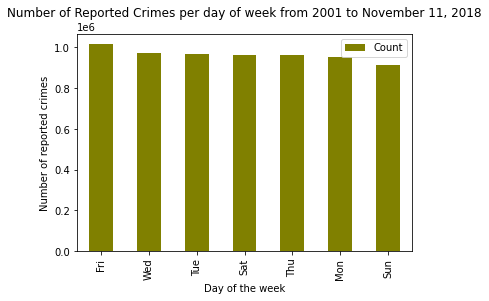

In [30]:
cp.sort_values("Count", ascending=False).plot(kind='bar', color='olive', x = 'Day_of_week', y = 'Count')
plt.xlabel('Day of the week')
plt.ylabel('Number of reported crimes')
plt.title('Number of Reported Crimes per day of week from 2001 to November 11, 2018')